# Figure showing emergence times of Arctic OLR with confidence intervals

__More extensive code in fig6_OLRemergence_full.ipynb__ I do a comparison between Leroy and Weatherhead there.

Calculate emergence using the Weatherhead-Shaw approach. When letting the forced response evolve (time dependence), emergence differences between the Weatherhead and Leroy estimates of $\tau_{var}$ were minor. We use the Weatherhead method because it also works for short observational periods.

## Load Data

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask, pd, xe
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time,
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Methods

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

Reformulation from Phojan et al. (2014):

$$ [\textrm{Var}(\hat{m})]^{1/2} \approx \left[ \frac{12}{T^3} \textrm{Var}(N_t) \tau_{W}  \right]^{1/2}, $$

where $N_t$ is the demeaned and detrended timeseries and $\tau_W$ is the Weatherhead correlation time given by

$$ \tau_W = \frac{1 + \phi}{1 - \phi}. $$

Time-to-emergence $\Delta t$. Emergence has occured if the length of the record exceeds the time-to-emergence.

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{W} \right]^{1/3}, $$

We will use the expression from Phojanamongkolkij (2014) because it is effectively the same as Leroy with a different expression for the correlation time. We take the lag-1 autocorrelation of the noise (taken from the PI-Control simulation), and the measured noise $\sigma_N$ (taken from the PI-Control simulation).

### Load CERES TOA data

I will interpolate these before calculating timeseries.

__TOA values through 2022/02. (only using 2001-2021)__

In [2]:
ceres_data_dir = '/glade/u/home/jonahshaw/w/obs/CERES/'
ceres_data_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_data_dir)

In [3]:
ceres_toa_ds = xr.open_mfdataset(ceres_data_files)

In [4]:
ceres_asr = ceres_toa_ds['solar_mon'] - ceres_toa_ds['toa_sw_all_mon']
ceres_olr = ceres_toa_ds['toa_lw_all_mon']

In [5]:
# I need a CESM1 file to interpolate to.

cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'
interp_file = 'FLUT/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.FLUT.192001-200512.nc'

interp_ds = xr.open_dataset('%s/%s' % (cesmle_path,interp_file))
interp_da = interp_ds['FLUT'].isel(time=0)

del interp_ds

In [6]:
regridder = xe.Regridder(ds_in=ceres_asr.isel(time=0),ds_out=interp_da,method='bilinear')

tsel = slice('2001-01-01','2021-12-31')

In [7]:
asr_regrid = regridder(ceres_asr)
olr_regrid = regridder(ceres_olr)

In [8]:
asr_arctic = asr_regrid.sel(lat=slice(70,None))
asr_arctic_wgtd = add_weights(asr_arctic)
asr_tseries = asr_arctic_wgtd.weighted(asr_arctic_wgtd['cell_weight']).mean(dim=['lat','lon']).sel(time=tsel)

In [9]:
olr_arctic = olr_regrid.sel(lat=slice(70,None))
olr_arctic_wgtd = add_weights(olr_arctic)
olr_tseries = olr_arctic_wgtd.weighted(olr_arctic_wgtd['cell_weight']).mean(dim=['lat','lon']).sel(time=tsel)

### Load pre-processed model timeseries

In [10]:
tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % tseries_savedir)

In [11]:
emerge_vars = ['FLUT','TS','FLUTC','FLUS']

In [12]:
# Calculate surface upwelling radiation. Is this right? 
# This just in FLUS = FLNS + FLDS. Found because rlus != FLDS - FLNS and CERES-EBAF agrees with rlus in magnitude.

# cesm1_pic_ds['FLUS'] = cesm1_pic_ds['FLDS'] - cesm1_pic_ds['FLNS']
# cesm1_ensresponse_ds['FLUS'] = cesm1_ensresponse_ds['FLDS'] - cesm1_ensresponse_ds['FLNS']

cesm1_pic_ds['FLUS'] = cesm1_pic_ds['FLDS'] + cesm1_pic_ds['FLNS']
cesm1_ensresponse_ds['FLUS'] = cesm1_ensresponse_ds['FLDS'] + cesm1_ensresponse_ds['FLNS']

In [13]:
pic_annavg  = {}
lens_annavg = {}

for _var in emerge_vars:
    
    # pic_tseries  = cesm1_pic_ds[_var]
    # lens_tseries = cesm1_ensresponse_ds[_var]
    
    pic_annavg[_var]  = cesm1_pic_ds[_var].groupby('time.year').mean(dim='time')
    lens_annavg[_var] = cesm1_ensresponse_ds[_var].groupby('time.year').mean(dim='time')


#### 1. Estimate internal variability of the unforced climate from the PI-Control simulation

Use the lag-1 autocorrelation to estimate $\tau_{var}$ per Weatherhead (1998).

In [14]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data):
    ''' Standardize the data. '''
    
    if data.std()==0: # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [15]:
# Implementation of Phojanamongkolkij's method:
def calc_tauvar2(autocorr,alpha=0.95):
    '''
    Calculate the autocorrelation time using Leroy (2008), with a selection of significant lags following Phojan.
    Taking sample coefficients at all available lags in estimating Leroy’s uncertainty of the trend will provide zero uncertainty;
    specifically, [the sum of the lagged correlations] is zero. Therefore, it is necessary to set up the criterion to determine which
    sample autocorrelation coefficients to include in the computation. The criterion used in this study is to
    include only the statistically significant [at 95%] coefficients up to 10 log10(T) lags in the summation.
    '''
    
    # the length of the autocorrelation is equal to the length of the timeseries
    N = len(autocorr)
    
    # lags up to "10 log10(T) lags in the summation"
    max_lag = int(10*np.log10(N))
    
    # Select autocorrelation only within a "max lag" of lag-0
    valid_autocorrs = autocorr[N//2-max_lag:N//2+max_lag+1]
    
    # calculate a critical t-statistic
    t_crit = stats.t.ppf((1+alpha)/2,df=N)

    # Calculate the statistical significance bound
    # $$ bound = t_{crit} / \sqrt{N}
    correlation_bound = t_crit / np.sqrt(N)
    
    # check if the autocorrelations are significant
    is_sig_bool = np.abs(valid_autocorrs) > correlation_bound

    # select the significant correlations and sum them to get the correlation time
    tau_var = np.sum(valid_autocorrs[is_sig_bool])
    
    return tau_var

In [16]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate


def calc_tauvar_wrapper2(data):
    """ Wrapper for the Phojanamongkolkij Method"""
    return xr.DataArray(calc_tauvar2(calc_autocorr(data)))

In [17]:
annual_lag1s  = {}
monthly_lag1s = {}

annual_tauvars_LP = {}
monthly_tauvars_LP = {}

annual_stddevs = {}
monthly_stddevs = {}

for _var in emerge_vars:
    
    _pic_tseries  = cesm1_pic_ds[_var]
    # lens_tseries = cesm1_ensresponse_ds[_var]
    
    _pic_annavg  = pic_annavg[_var]
    # lens_annavg = lens_tseries.groupby('time.year').mean(dim='time')
    
    # Calculate autocorrelations
    _annual_lag1 = calc_lag1_autocorr(_pic_annavg)
    _annual_lag1.name = _var

    _monthly_lag1 = _pic_tseries.groupby('time.month').map(calc_lag1_autocorr)
    _monthly_lag1.name = _var

    # Calculate correlation times (Leroy + Phojanamongkolkij)
    _annual_tauvar_LP  = calc_tauvar_wrapper2(_pic_annavg)
    _annual_tauvar_LP.name = _var

    _monthly_tauvar_LP = _pic_tseries.groupby('time.month').map(calc_tauvar_wrapper2)
    _monthly_tauvar_LP.name = _var

    # Calculate the standard deviation of internal OLR variability
    _annual_stddev  = _pic_annavg.std()
    _monthly_stddev = _pic_tseries.groupby('time.month').map(xr.DataArray.std)
    
    # Store all
    annual_lag1s[_var]  = _annual_lag1
    monthly_lag1s[_var] = _monthly_lag1
    
    annual_tauvars_LP[_var]  = _annual_tauvar_LP
    monthly_tauvars_LP[_var] = _monthly_tauvar_LP

    annual_stddevs[_var]  = _annual_stddev
    monthly_stddevs[_var] = _monthly_stddev

#### 2. Calculate a regressed trend for each ensemble member at each additional timestep

Functions.

In [19]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

def calc_slopes_by_dur(data,ann_tsel,durations,calc_detrended=False):
    '''Wrapper for calculating slopes for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_slopes_by_dur_DATASET(data,ann_tsel,durations,calc_detrended=calc_detrended)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_slopes_by_dur_DATAARRAY(data,ann_tsel,durations,calc_detrended=calc_detrended)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')
        return None

        
def __calc_slopes_by_dur_DATASET(data,ann_tsel,durations,calc_detrended=False):
    
    annavg_slopes_dict  = {}
    monthly_slopes_dict = {}

    if calc_detrended:
        annavg_detrend_dict  = {}
        monthly_detrend_dict = {}
            
    for _var in data.data_vars:    
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        lens_slopes_dict = {}
        lens_slopes_monthly_dict = {}
        
        if calc_detrended:
            lens_detrend_dict = {}
            lens_detrend_monthly_dict = {}
        
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
            _lens_slopes = _lens_polyfit['polyfit_coefficients'] # pull out the slope from the linear fit

            _lens_polyfit_monthly = tseries_dur_monthly_subset.groupby('time.month').map(linear_polyfit)
            _lens_slopes_monthly  = _lens_polyfit_monthly['polyfit_coefficients']

            # Add a 'duration' coordinate
            _lens_slopes = _lens_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            _lens_slopes_monthly = _lens_slopes_monthly.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            
            lens_slopes_dict[_dur] = _lens_slopes # save slopes in an inner dictionary
            lens_slopes_monthly_dict[_dur] = _lens_slopes_monthly
                        
            ###### Calculate detrended data
            if calc_detrended:
                _linear_tseries_ann     = _lens_slopes.sel(degree=1)*tseries_dur_subset['year'] + _lens_slopes.sel(degree=0)
            
                _detrended_tseries_ann     = _linear_tseries_ann - tseries_dur_subset.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)            
                _detrended_tseries_monthly = tseries_dur_monthly_subset.groupby('time.month').map(monthly_detrend_helper,coeffs=_lens_slopes_monthly)

                _detrended_tseries_ann.name = _var
                _detrended_tseries_monthly.name = _var

                lens_detrend_dict[_dur]         = _detrended_tseries_ann
                lens_detrend_monthly_dict[_dur] = _detrended_tseries_monthly
        
        # combine the data along the new 'duration' dimension
        # try:
        #     _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']
        # except:
        #     _temp_slopes_da = xr.concat(list(lens_slopes_dict.values()),dim='duration')
        _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']    
        _temp_slopes_da.name = _var
        
        # try:
        #     _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
        # except:
        #     _temp_slopes_monthly_da = xr.concat(list(lens_slopes_monthly_dict.values()),dim='duration')
        _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
        _temp_slopes_monthly_da.name = data.name

        annavg_slopes_dict[_var] = _temp_slopes_da
        monthly_slopes_dict[_var] = _temp_slopes_monthly_da
        
        del lens_slopes_dict,lens_slopes_monthly_dict
        
        if calc_detrended:
            _temp_detrend_da = xr.merge(list(lens_detrend_dict.values()))
            _temp_detrend_monthly_da = xr.merge(list(lens_detrend_monthly_dict.values()))
            
            annavg_detrend_dict[_var]  = _temp_detrend_da
            monthly_detrend_dict[_var] = _temp_detrend_monthly_da
            
            del lens_detrend_dict,lens_detrend_monthly_dict

    data_slopes_dur_ds = xr.merge(annavg_slopes_dict.values()).sel(degree=1).drop('degree')
    data_slopes_monthly_dur_ds = xr.merge(monthly_slopes_dict.values()).sel(degree=1).drop('degree')
        
    if calc_detrended:
        data_detrend_dur_ds = xr.merge(annavg_detrend_dict.values())
        data_detrend_monthly_dur_ds = xr.merge(monthly_detrend_dict.values())

        del annavg_slopes_dict,monthly_slopes_dict,annavg_detrend_dict,monthly_detrend_dict
        return data_slopes_dur_ds,data_slopes_monthly_dur_ds,data_detrend_dur_ds,data_detrend_monthly_dur_ds
        
    else:
        del annavg_slopes_dict,monthly_slopes_dict
        return data_slopes_dur_ds,data_slopes_monthly_dur_ds

### Doesn't work but maybe one day will!
# def __calc_slopes_by_dur_DATASET(data,ann_tsel,durations,calc_detrended=True):
#     return data.map(__calc_slopes_by_dur_DATAARRAY,ann_tsel=ann_tsel,durations=durations,calc_detrended=calc_detrended)
    
def __calc_slopes_by_dur_DATAARRAY(data,ann_tsel,durations,calc_detrended=False):
    
    ens_tseries = data # select your variable
    
    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)
    
    lens_slopes_dict = {}
    lens_slopes_monthly_dict = {}
    
    if calc_detrended:
        lens_detrend_dict = {}
        lens_detrend_monthly_dict = {}
        
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
        _lens_slopes = _lens_polyfit['polyfit_coefficients'].compute() # pull out the slope from the linear fit

        _lens_polyfit_monthly = tseries_dur_monthly_subset.groupby('time.month').map(linear_polyfit)
        _lens_slopes_monthly  = _lens_polyfit_monthly['polyfit_coefficients'].compute()

        # Add a 'duration' coordinate
        _lens_slopes = _lens_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        _lens_slopes_monthly = _lens_slopes_monthly.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        # save slopes in an inner dictionary
        lens_slopes_dict[_dur] = _lens_slopes.sel(degree=1).drop('degree')#.compute()
        lens_slopes_monthly_dict[_dur] = _lens_slopes_monthly.sel(degree=1).drop('degree')#.compute()
        
        ###### Calculate detrended data
        if calc_detrended:
            _linear_tseries_ann     = _lens_slopes.sel(degree=1)*tseries_dur_subset['year'] + _lens_slopes.sel(degree=0)
            
            _detrended_tseries_ann     = _linear_tseries_ann - tseries_dur_subset.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)            
            _detrended_tseries_monthly = tseries_dur_monthly_subset.groupby('time.month').map(monthly_detrend_helper,coeffs=_lens_slopes_monthly)
                        
            _detrended_tseries_ann.name = data.name
            _detrended_tseries_monthly.name = data.name
            
            lens_detrend_dict[_dur]         = _detrended_tseries_ann
            lens_detrend_monthly_dict[_dur] = _detrended_tseries_monthly

    # combine the data along the new 'duration' dimension
    # errors here with lower dimensional data, move the drop degree step earlier
    _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']
    # try:
    #     _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']
    # except:
    #     return lens_slopes_dict
    #     _temp_slopes_da = xr.concat(list(lens_slopes_dict.values()),dim='duration')
    _temp_slopes_da.name = data.name

    _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
    # try:
    #     _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
    # except:
    #     _temp_slopes_monthly_da = xr.concat(list(lens_slopes_monthly_dict.values()),dim='duration')
    _temp_slopes_monthly_da.name = data.name

    _temp_slopes_da = _temp_slopes_da#.sel(degree=1).drop('degree')
    _temp_slopes_monthly_da = _temp_slopes_monthly_da#.sel(degree=1).drop('degree')

    if calc_detrended:
        _temp_detrend_da = xr.merge(list(lens_detrend_dict.values()))
        _temp_detrend_monthly_da = xr.merge(list(lens_detrend_monthly_dict.values()))

        del lens_slopes_dict,lens_slopes_monthly_dict,lens_detrend_dict,lens_detrend_monthly_dict
        return _temp_slopes_da,_temp_slopes_monthly_da,_temp_detrend_da,_temp_detrend_monthly_da

    else:
        del lens_slopes_dict,lens_slopes_monthly_dict
        return _temp_slopes_da,_temp_slopes_monthly_da    

def monthly_detrend_helper(tseries,coeffs=None):
    '''
    Helper function (poorly coded) to detrend monthly timeseries if given the linear fit coefficients.
    '''

    month = tseries[0]['time.month']
    years = tseries['time.year']

    coeff0 = coeffs.sel(month=month,degree=0)
    coeff1 = coeffs.sel(month=month,degree=1)

    proxy_tseries = coeff1*years + coeff0 # y = mx+b

    _detrended_tseries_monthly = proxy_tseries - tseries
    _detrended_tseries_monthly = _detrended_tseries_monthly.groupby('time.year').mean('time') # shift from the full 'time' coordinate to a 'year' coordinate

    return _detrended_tseries_monthly

In [20]:
durations = np.arange(2,80)

Calculate slopes for the model data

In [21]:
%%time

slopes_annual  = {}
slopes_monthly = {}

for _var in emerge_vars:
    _slopes_ann,_slopes_monthly = calc_slopes_by_dur(cesm1_ensresponse_ds[_var],ann_tsel=slice('2001-01-01',None),durations=durations)
    
    slopes_annual[_var]  = _slopes_ann
    slopes_monthly[_var] = _slopes_monthly

CPU times: user 15.5 s, sys: 190 ms, total: 15.7 s
Wall time: 17 s


In [22]:
slopes_annual_ds  = xr.merge(list(slopes_annual.values()))
slopes_monthly_ds = xr.merge(list(slopes_monthly.values()))

slopes_all_ds = xr.merge([slopes_monthly_ds,slopes_annual_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

Calculate slopes for the observational data

In [ ]:
# the function breaks for trends of 2-year apparently...? This gives wrong values for the observational data, but not the model output?
# olr_slopes_ann,olr_slopes_monthly = calc_slopes_by_dur(asr_tseries,ann_tsel=slice('2001-01-01',None),durations=np.arange(3,22)) 

Calculate slopes for the observational data (manually because my code is messing up for some reason...

In [ ]:
monthly_olr_slopes = []
annual_olr_slopes  = []

olr_tseries_ann = olr_tseries.groupby('time.year').mean(dim='time')

for _dur in np.arange(3,22):
    
    monthly_tsubset = olr_tseries.isel(time=slice(None,12*_dur))
    annual_tsubset  = olr_tseries_ann.isel(year=slice(None,_dur))
    
    monthly_polyfit = monthly_tsubset.groupby('time.month').map(linear_polyfit)
    annual_polyfit  = annual_tsubset.polyfit(dim='year',deg=1)
    
    monthly_slopes  = monthly_polyfit['polyfit_coefficients'].sel(degree=1).drop('degree')
    annual_slopes   = annual_polyfit['polyfit_coefficients'].sel(degree=1).drop('degree')
    
    monthly_slopes_out = monthly_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
    annual_slopes_out  = annual_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
    
    monthly_olr_slopes.append(monthly_slopes_out)
    annual_olr_slopes.append(annual_slopes_out)

monthly_olr_slopes_da = xr.concat(monthly_olr_slopes,dim='duration').compute()
annual_olr_slopes_da  = xr.concat(annual_olr_slopes,dim='duration').compute()

#### 3. Use the Weatherhead/Leroy/Phojanamongkolkij approach to calculate time-to-emergence for each ensemble member

Emergence occurs when the climate signal exits internal variability for the LAST time.

Calculate predicted time-to-emergence 

In [24]:
TTE_annual_LP_all  = {}
TTE_monthly_LP_all = {}

s = 2

for _var in emerge_vars:
    # time calculated using a correlation time from the summing method 
    _TTE_annual_LP  = (12*s**2 * annual_stddevs[_var]**2 * annual_tauvars_LP[_var] / slopes_annual[_var]**2)**(1/3)
    _TTE_monthly_LP = (12*s**2 * monthly_stddevs[_var]**2 * monthly_tauvars_LP[_var] / slopes_monthly[_var]**2)**(1/3)
    
    TTE_annual_LP_all[_var]  = _TTE_annual_LP
    TTE_monthly_LP_all[_var] = _TTE_monthly_LP

In [25]:
ceresolr_TTE_annual_LP  = (12*s**2 * annual_stddevs['FLUT']**2 * annual_tauvars_LP['FLUT'] / annual_olr_slopes_da**2)**(1/3)
ceresolr_TTE_monthly_LP = (12*s**2 * monthly_stddevs['FLUT']**2 * monthly_tauvars_LP['FLUT'] / monthly_olr_slopes_da**2)**(1/3)

October is super close to emergence if we ignore observational uncertainty.

__Translate to an emergence time (when the signal exits internal variability for the last time).__

In [26]:
def emergence_wrapper(TTE_data):
    detect_ds = TTE_data < TTE_data.duration
    duration_broad = detect_ds.duration.broadcast_like(detect_ds)
    
    emergence_ds = 1 + duration_broad.where(~detect_ds).max(dim='duration')
    
    return emergence_ds

In [27]:
emergence_LP_allvar = {}

for _var in emerge_vars:
    
    # calculate emergence
    _emergence_LP_annual_ds  = emergence_wrapper(TTE_annual_LP_all[_var])
    _emergence_LP_monthly_ds = emergence_wrapper(TTE_monthly_LP_all[_var])
    
    # Merge the monthly and annual emergence values.
    _emergence_LP_all = xr.merge([_emergence_LP_monthly_ds,_emergence_LP_annual_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])['duration']
    
    emergence_LP_allvar[_var] = _emergence_LP_all

In [28]:
ceresolr_emergence_annual  = emergence_wrapper(ceresolr_TTE_annual_LP)
ceresolr_emergence_monthly = emergence_wrapper(ceresolr_TTE_monthly_LP)

I don't think that this was working...but now it tells me that none of these months have emerged? Surprising but not really when we compare where the actual trends are vs. where we expect them to be.

Get trends at the time of mean emergence for "variability_comparison.ipynb".

In [29]:
trends_at_emerge = []

for month_emerge,month_trends in zip(emergence_LP_allvar['FLUT'].mean(dim='ens'),slopes_monthly['FLUT'].mean(dim='ens')):
    # print(month_emerge)
    
    emerge_trend =  month_trends.sel(duration=month_emerge,method='nearest')
    trends_at_emerge.append(emerge_trend)
    
    # break
trends_at_emerge = np.array(trends_at_emerge)

In [30]:
trends_at_emerge

array([0.1559884 , 0.12656918, 0.10751845, 0.08802388, 0.06608555,
       0.05506862, 0.04973755, 0.07845972, 0.12724987, 0.19600438,
       0.22476607, 0.19423492])

__Add asymmetry and use bootstrapping to limit the effect outliers.__

Just Leroy estimates bootstrapped -->

In [31]:
%%time 

emergence_LP_allvars = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
for _var in emerge_vars:
    print(_var)

    data = emergence_LP_allvar[_var]

    N_ens = len(data['ens']) # number of members

    # Compute percentiles using bootstrapping
    lower_percentile = []
    upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 1)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=1)
        # compute percentiles along the ensemble dimension (axis 1)
        lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=1))
        upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=1))
        mean_emergence.append(np.mean(resample_emergence,axis=1))

    _lower_emerge_bstrap = np.mean(lower_percentile,axis=0) # take the mean percentile along the correct axis
    _upper_emerge_bstrap = np.mean(upper_percentile,axis=0)
    _mean_emerge_bstrap  = np.mean(mean_emergence,axis=0)


    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
        dims=["bound","month"],
        coords=dict(
            bound=[lower_bound,50,upper_bound], # bounds are percentiles now
            month=np.arange(1,14,1),
        ),
        name = _var
    )
    
    emergence_LP_allvars[_var] = _emergence_LP_da

FLUT
TS
FLUTC
FLUS
CPU times: user 4.61 s, sys: 2.56 ms, total: 4.61 s
Wall time: 4.68 s


#### Plot for Paper

Without bootstrapping (just the t-test).

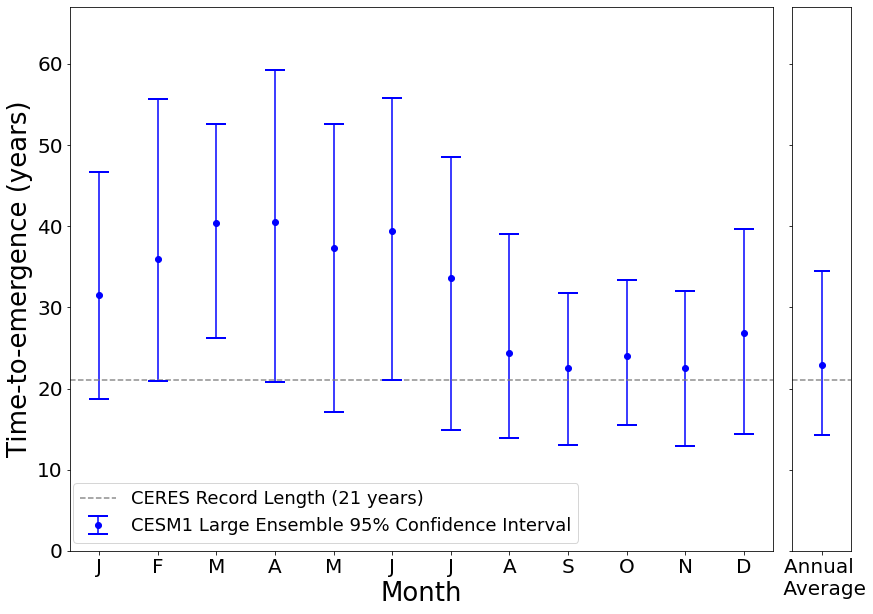

In [32]:
olr_emergence_test = emergence_LP_allvars['FLUT']

low_err  = olr_emergence_test.sel(bound=50,method='nearest') - olr_emergence_test.sel(bound=2.5,method='nearest')
high_err = olr_emergence_test.sel(bound=97.5,method='nearest') - olr_emergence_test.sel(bound=50,method='nearest')

fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.errorbar(olr_emergence_test.sel(month=slice(1,12)).month, 
             olr_emergence_test.sel(bound=50,month=slice(1,12)), 
             yerr=[low_err.sel(month=slice(1,12)),high_err.sel(month=slice(1,12))],
             fmt="o",
             label='CESM1 Large Ensemble 95% Confidence Interval',
             dash_capstyle='butt',
             # color='black',
             color='blue',
             capsize=10,
             capthick=2,
            )

ax2.errorbar(1, 
             olr_emergence_test.sel(bound=50,month=13), 
             yerr=[[low_err.sel(month=13)],[high_err.sel(month=13)]], # needs to have shape (2,1)
             fmt="o",
             dash_capstyle='butt',
             # color='black',
             color='blue',
             capsize=8,
             capthick=2,
            )

ax1.set_ylim(0,67)
ax1.set_xlim(0.5,12.5)
ax1.set_ylabel('Time-to-emergence (years)',fontsize=26)
ax1.set_xlabel('Month',fontsize=26)

ax1.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
# exp_det_ax.yticks(fontsize=15)

ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)')

ax2.set_xlim(0.5,1.5)
ax2.set_ylim(0,67)

ax2.set_xticks([1])
ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelsize=20)
ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9)

ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# ax1.set_title('95% confidence intervals on OLR emergence',fontsize=28)


In [33]:
to_png(file=fig,filename='fig_OLRemergence',dpi=300,ext='pdf',bbox_inches='tight')

In [34]:
# new_fig,new_ax = plt.subplots(1,2,figsize=(20,10))

# #### Code taken from fig7_OLR_by_layer.ipynb

# # annual_stddevs['FLUT']**2 * annual_tauvars_LP['FLUT']
# # monthly_stddevs['FLUT']**2 * monthly_tauvars_LP['FLUT']

# ### Standard Deviation
# new_ax[0].plot(np.arange(1,13),monthly_stddevs['FLUS'],
#                    linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8)

# new_ax[0].plot(np.arange(1,13),monthly_stddevs['FLUTC'],
#                    linestyle='dashed',label='Clear-sky OLR',color='black',linewidth=3,alpha=0.8)

# new_ax[0].plot(np.arange(1,13),monthly_stddevs['FLUT'],
#                    linestyle='dashed',label='OLR',color='orange',linewidth=3,alpha=0.8)

# new_ax[0].set_ylim(0,10)
# new_ax[0].tick_params(axis='y', labelsize=18)
# new_ax[0].set_ylabel('Longwave Radiation Standard Deviation (Wm$^{-2}$)',fontsize=20)

# month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

# new_ax[0].set_xticks(np.arange(1,13))
# new_ax[0].set_xticklabels(month_abbrevs[:-1],fontsize=20)
# new_ax[0].set_xlabel('Month',fontsize=20)
# new_ax[0].set_xlim(0.75,12.25)

# new_ax[1].plot(np.arange(1,13),monthly_tauvars_LP['FLUS'],
#                linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8)

# new_ax[1].plot(np.arange(1,13),monthly_tauvars_LP['FLUTC'],
#                linestyle='dashed',label='Clear-sky OLR',color='black',linewidth=3,alpha=0.8)

# new_ax[1].plot(np.arange(1,13),monthly_tauvars_LP['FLUT'],
#                linestyle='dashed',label='OLR',color='orange',linewidth=3,alpha=0.8)

# new_ax[1].set_ylim(0.8,2.5)
# new_ax[1].tick_params(axis='y', labelsize=18)
# new_ax[1].set_ylabel('Longwave Radiation Correlation Time (Wm$^{-2}$)',fontsize=20)

# month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

# new_ax[1].set_xticks(np.arange(1,13))
# new_ax[1].set_xticklabels(month_abbrevs[:-1],fontsize=20)
# new_ax[1].set_xlabel('Month',fontsize=20)
# new_ax[1].set_xlim(0.75,12.25)

# props = dict(facecolor='white', alpha=1)

# new_ax[0].text(1,9.5,'a',fontsize=22,bbox=props)
# new_ax[1].text(1,2.42,'b',fontsize=22,bbox=props)

# # new_fig.suptitle('Monthly OLR Trends by Layer',fontsize=20,y=0.92)

# # new_ax[1].legend(fontsize=18,loc='upper left')

In [35]:
# to_png(file=new_fig,filename='fig_variability_bylayer',dpi=300,ext='pdf',bbox_inches='tight')

(0.0, 16.0)

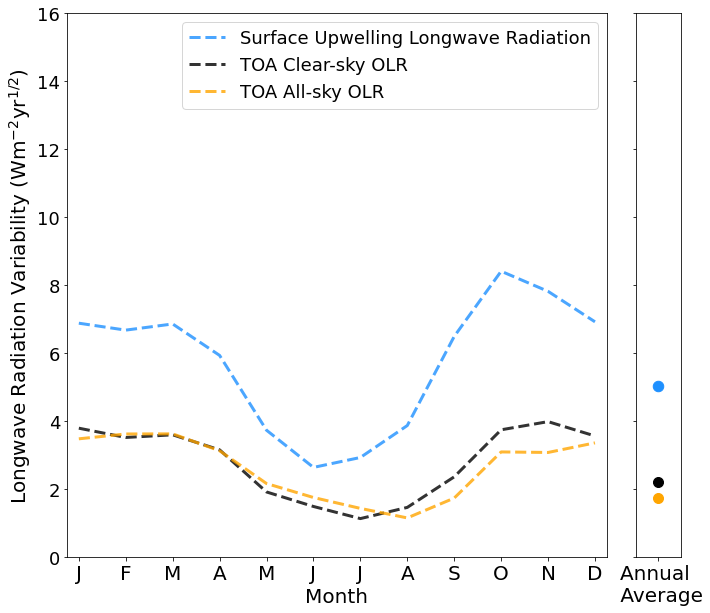

In [40]:
var_fig = plt.figure(figsize=(11,10))

# colors = ['purple','black','orange']
# colors = ['red','blue','black']
# colors = ['lightblue','black','orange']
colors = ['dodgerblue','black','orange']

gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=var_fig,wspace=0.1)

var_ax = plt.subplot(gs[0]) # months
var_ax_monthly = plt.subplot(gs[1]) # annual

#### Plot code taken from fig7_OLR_by_layer.ipynb
annual_stddevs_ds = xr.merge(annual_stddevs.values())
monthly_stddevs_ds = xr.merge(monthly_stddevs.values())

annual_tauvars_LP_ds = xr.merge(annual_tauvars_LP.values())
monthly_tauvars_LP_ds = xr.merge(monthly_tauvars_LP.values())

# netvar_annual  = (annual_stddevs_ds**2 * annual_tauvars_LP_ds).map(np.sqrt)
# netvar_monthly = (monthly_stddevs_ds**2 * monthly_tauvars_LP_ds).map(np.sqrt)

netvar_annual  = annual_stddevs_ds * annual_tauvars_LP_ds.map(np.sqrt)
netvar_monthly = monthly_stddevs_ds * monthly_tauvars_LP_ds.map(np.sqrt)

var_ax.plot(np.arange(1,13),netvar_monthly['FLUS'],
            linestyle='dashed',label='Surface Upwelling Longwave Radiation',color=colors[0],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly['FLUTC'],
            linestyle='dashed',label='TOA Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly['FLUT'],
            linestyle='dashed',label='TOA All-sky OLR',color=colors[2],linewidth=3,alpha=0.8)

# var_ax.set_ylim(0,10)
var_ax.tick_params(axis='y', labelsize=18)
var_ax.set_ylabel('Longwave Radiation Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
# var_ax.set_ylabel('Longwave Radiation Standard Deviation (Wm$^{-2}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

var_ax.set_xticks(np.arange(1,13))
var_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
var_ax.set_xlabel('Month',fontsize=20)
var_ax.set_xlim(0.75,12.25)
var_ax.set_ylim(0,16)

var_ax.legend(fontsize=18)

var_ax_monthly.scatter(1,netvar_annual['FLUS'],
                    color=colors[0],s=110,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )

var_ax_monthly.scatter(1,netvar_annual['FLUTC'],
                    color=colors[1],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )

var_ax_monthly.scatter(1,netvar_annual['FLUT'],
                    color=colors[2],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )
                
var_ax_monthly.set_xlim(0.5,1.5)
# var_ax_monthly.set_ylim(0,0.6)

var_ax_monthly.set_xticks([1])
var_ax_monthly.set_xticklabels(['Annual \n Average'],fontsize=20)
var_ax_monthly.set_yticklabels([])
var_ax_monthly.tick_params(axis='y', labelsize=20)

var_ax_monthly.set_ylim(0,16)

\textbf{Monthly and annual variability of longwave radiation variables estimated from the CESM1 pre-industrial control simulation.} Purple lines show surface OLR emergence. Black lines show top-of-atmosphere clear-sky OLR emergence. Yellow lines show top-of-atmosphere OLR emergence.

In [41]:
to_png(file=var_fig,filename='fig_netvariability_bylayer_corrected',dpi=300,ext='pdf',bbox_inches='tight')

Motivate this in the methods by mentioning that the variability term analogous to the forced trend is $\sigma_{var} \tau_{var}^{1/2}$

### Trends by layer

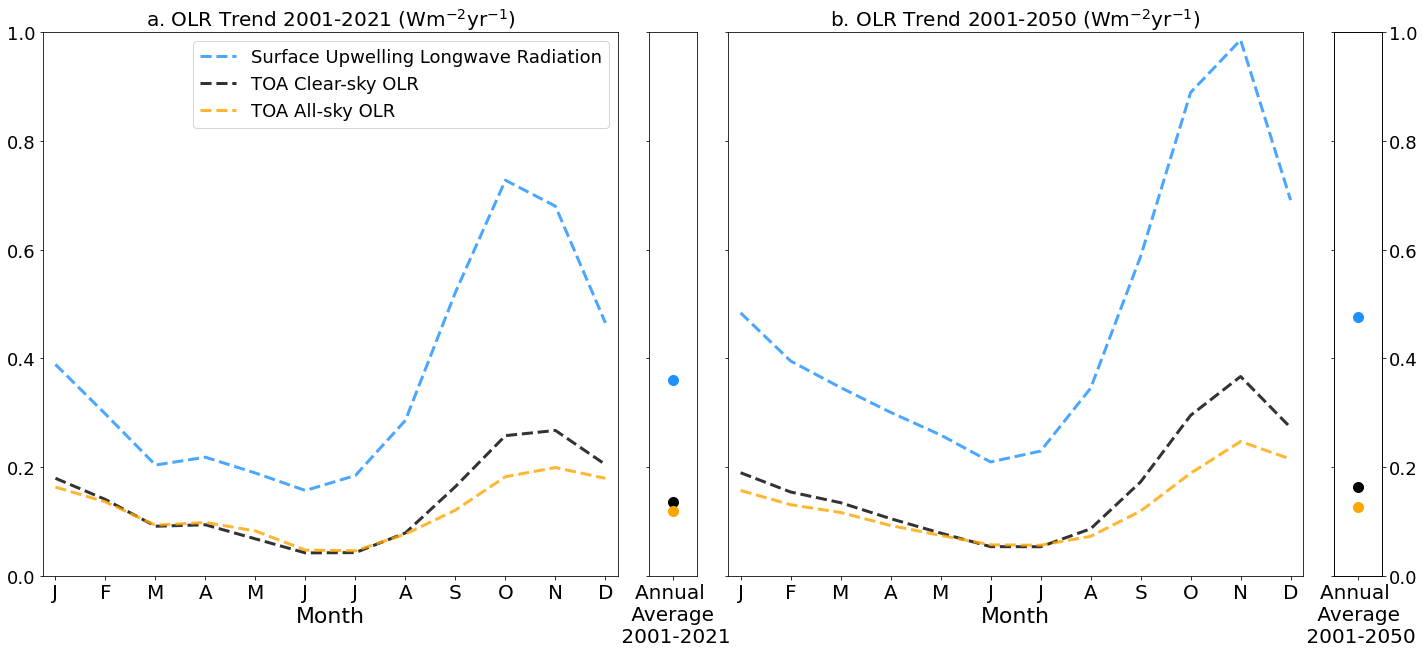

In [51]:
# new_fig,new_ax = plt.subplots(1,3,figsize=(30,10))
# colors = ['purple','black','orange']
colors = ['dodgerblue','black','orange']

fig = plt.figure(figsize=(24,10))

gs = gridspec.GridSpec(1,4,width_ratios=[12,1,12,1],figure=fig,wspace=0.1)

ceres_ax = plt.subplot(gs[0]) # months
ceres_ax_annual = plt.subplot(gs[1]) # annual

mid_ax = plt.subplot(gs[2]) # months
mid_ax_annual = plt.subplot(gs[3]) # annual

slopes_2001_2021 = slopes_all_ds.sel(duration=21).mean(dim='ens')
slopes_2001_2050 = slopes_all_ds.sel(duration=50).mean(dim='ens')

slopestddevs_2001_2021 = slopes_all_ds.sel(duration=21).std(dim='ens')
slopestddevs_2001_2050 = slopes_all_ds.sel(duration=50).std(dim='ens')

#### 2001-2021
ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2021['FLUS'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='Surface Upwelling Longwave Radiation',color=colors[0],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2021['FLUTC'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='TOA Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2021['FLUT'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='TOA All-sky OLR',color=colors[2],linewidth=3,alpha=0.8)

ceres_ax.set_ylim(0,1)
# ceres_ax.set_ylim(-0.1,1)
ceres_ax.tick_params(axis='y', labelsize=18)
# ceres_ax.set_ylabel('OLR Trend 2001-2021 (Wm$^{-2}$)',fontsize=20)
ceres_ax.set_title('a. OLR Trend 2001-2021 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

ceres_ax.set_xticks(np.arange(1,13))
ceres_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
ceres_ax.set_xlabel('Month',fontsize=22)
ceres_ax.set_xlim(0.75,12.25)

ceres_ax.legend(fontsize=18)

ceres_ax_annual.scatter(1,slopes_2001_2021['FLUS'].sel(month=13),
                        color=colors[0],s=100,
                       )

ceres_ax_annual.scatter(1,slopes_2001_2021['FLUTC'].sel(month=13),
                        color=colors[1],s=100,
                       )

ceres_ax_annual.scatter(1,slopes_2001_2021['FLUT'].sel(month=13),
                        color=colors[2],s=100,
                       )

# Could add error bars here using: slopestddevs_2001_2021

ceres_ax_annual.set_xticks([1])
ceres_ax_annual.set_xticklabels(['Annual \n Average \n 2001-2021'],fontsize=20)
ceres_ax_annual.set_yticklabels([])
ceres_ax_annual.tick_params(axis='y', labelsize=20)

ceres_ax_annual.set_xlim(0.5,1.5)
ceres_ax_annual.set_ylim(0,1)
# ceres_ax_annual.set_ylim(-0.1,1)


# new_ax[0].legend(fontsize=18,loc='upper right')
# new_ax[0].set_title('2001-2021',fontsize=20,y=1)

#### 2001-2050
mid_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUS'].sel(month=slice(1,12)),yerr=None,
                   linestyle='dashed',label='Surface OLR',color=colors[0],linewidth=3,alpha=0.8)

mid_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUTC'].sel(month=slice(1,12)),yerr=None,
                   linestyle='dashed',label='Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

mid_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUT'].sel(month=slice(1,12)),yerr=None,
                   linestyle='dashed',label='OLR',color=colors[2],linewidth=3,alpha=0.8)

mid_ax.set_ylim(0,1)
# mid_ax.set_ylim(-0.1,1)
mid_ax.tick_params(axis='y', labelsize=18)
# mid_ax.set_ylabel('OLR Trend 2001-2050 (Wm$^{-2}$)',fontsize=20)
mid_ax.set_title('b. OLR Trend 2001-2050 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

mid_ax.set_xticks(np.arange(1,13))
mid_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
mid_ax.set_xlabel('Month',fontsize=22)
mid_ax.set_xlim(0.75,12.25)

mid_ax.set_yticklabels([])


mid_ax_annual.scatter(1,slopes_2001_2050['FLUS'].sel(month=13),
                        color=colors[0],s=100,
                       )

mid_ax_annual.scatter(1,slopes_2001_2050['FLUTC'].sel(month=13),
                        color=colors[1],s=100
                       )

mid_ax_annual.scatter(1,slopes_2001_2050['FLUT'].sel(month=13),
                        color=colors[2],s=100,
                       )

mid_ax_annual.set_xticks([1])
mid_ax_annual.set_xticklabels(['Annual \n Average \n 2001-2050'],fontsize=20)
mid_ax_annual.set_yticklabels([])
mid_ax_annual.tick_params(axis='y', labelsize=20)

mid_ax_annual.set_xlim(0.5,1.5)
mid_ax_annual.set_ylim(0,1)
# mid_ax_annual.set_ylim(-0.1,1)

mid_ax_annual_b = mid_ax_annual.twinx()
# mid_ax_annual_b.set_ylim(-0.1,1)
mid_ax_annual_b.set_ylim(0,1)
mid_ax_annual_b.tick_params(axis='y', labelsize=18)


In [47]:
to_png(file=fig,filename='fig_trends_bylayer_corrected',dpi=300,ext='pdf',bbox_inches='tight')

Addressing a comment from Anne:

You could put in some numbers: 'surface OLR trends increase by upwards of % while TOA OLR trends only change by %'.  

This comment is made with respect to this line:
“When the record is extended through the first half of the 21st century, however, surface upwelling longwave radiation increases but TOA OLR is largely unchanged.”

In [64]:
print('2001-2021 Surface ULR trend (annual avg.): ', slopes_2001_2021['FLUS'].sel(month=13).values)

print('2001-2050 Surface ULR trend (annual avg.): ', slopes_2001_2050['FLUS'].sel(month=13).values)

# pct_change = (slopes_2001_2050['FLUS'].sel(month=13) - slopes_2001_2021['FLUS'].sel(month=13)) / slopes_2001_2021['FLUS'].sel(month=13)
pct_change = (slopes_2001_2050['FLUS'] - slopes_2001_2021['FLUS']) / slopes_2001_2021['FLUS']
print('Percent change (Surface ULR trend): ',pct_change)

2001-2021 Surface ULR trend (annual avg.):  0.35995107679370314
2001-2050 Surface ULR trend (annual avg.):  0.47682593023210573
Percent change (Surface ULR trend):  <xarray.DataArray 'FLUS' (month: 13)>
array([0.24354535, 0.32790067, 0.69948739, 0.37825018, 0.37033888,
       0.33475746, 0.24308903, 0.20649111, 0.12594197, 0.22185155,
       0.44961725, 0.48543842, 0.3246965 ])
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
    duration  int64 21


In [66]:
print('2001-2021 TOA OLR trend (annual avg.): ', slopes_2001_2021['FLUT'].sel(month=13).values)

print('2001-2050 TOA OLR trend (annual avg.): ', slopes_2001_2050['FLUT'].sel(month=13).values)

# pct_change = (slopes_2001_2050['FLUT'].sel(month=13) - slopes_2001_2021['FLUT'].sel(month=13)) / slopes_2001_2021['FLUT'].sel(month=13)
pct_change = (slopes_2001_2050['FLUT'] - slopes_2001_2021['FLUT']) / slopes_2001_2021['FLUT']

print('Percent change (TOA OLR Trend): ',pct_change)

2001-2021 TOA OLR trend (annual avg.):  0.1187015631122416
2001-2050 TOA OLR trend (annual avg.):  0.12718988529050484
Percent change (TOA OLR Trend):  <xarray.DataArray 'FLUT' (month: 13)>
array([-0.03858257, -0.0382573 ,  0.2511743 , -0.05670621, -0.09925702,
        0.2041663 ,  0.22061277, -0.05390708, -0.01386142,  0.03519231,
        0.2406586 ,  0.19734998,  0.07150978])
Coordinates:
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
    duration  int64 21


### Emergence by layer figure

In [44]:
# olr_emergence = emergence_LP_allvars['FLUT']

# low_err_olr  = olr_emergence_test.sel(bound=50,method='nearest') - olr_emergence_test.sel(bound=2.5,method='nearest')
# high_err_olr = olr_emergence_test.sel(bound=97.5,method='nearest') - olr_emergence_test.sel(bound=50,method='nearest')

# olrc_emergence = emergence_LP_allvars['FLUTC']

# low_err_olrc  = olrc_emergence.sel(bound=50,method='nearest') - olrc_emergence.sel(bound=2.5,method='nearest')
# high_err_olrc = olrc_emergence.sel(bound=97.5,method='nearest') - olrc_emergence.sel(bound=50,method='nearest')

# olrs_emergence = emergence_LP_allvars['FLUS']

# low_err_olrs  = olrs_emergence.sel(bound=50,method='nearest') - olrs_emergence.sel(bound=2.5,method='nearest')
# high_err_olrs = olrs_emergence.sel(bound=97.5,method='nearest') - olrs_emergence.sel(bound=50,method='nearest')

# fig = plt.figure(figsize=(14,10))

# gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=fig,wspace=0.05)

# ax1 = plt.subplot(gs[0])
# ax2 = plt.subplot(gs[1])

# ax1.errorbar(olrs_emergence.sel(month=slice(1,12)).month-0.25,
#              olrs_emergence.sel(bound=50,month=slice(1,12)), 
#              yerr=[low_err_olrs.sel(month=slice(1,12)),high_err_olrs.sel(month=slice(1,12))],
#              fmt="o",
#              label='Surface OLR',
#              dash_capstyle='butt',
#              color='purple',
#              capsize=6,
#              capthick=2,
#             )

# ax1.errorbar(olrc_emergence.sel(month=slice(1,12)).month, 
#              olrc_emergence.sel(bound=50,month=slice(1,12)), 
#              yerr=[low_err_olrc.sel(month=slice(1,12)),high_err_olrc.sel(month=slice(1,12))],
#              fmt="o",
#              label='Clear-sky OLR',
#              dash_capstyle='butt',
#              color='black',
#              capsize=6,
#              capthick=2,
#             )

# ax1.errorbar(olr_emergence.sel(month=slice(1,12)).month+0.25, 
#              olr_emergence.sel(bound=50,month=slice(1,12)), 
#              yerr=[low_err_olr.sel(month=slice(1,12)),high_err_olr.sel(month=slice(1,12))],
#              fmt="o",
#              label='OLR',
#              dash_capstyle='butt',
#              color='orange',
#              capsize=6,
#              capthick=2,
#             )

# ### Annual values
# ax2.errorbar(0.75, 
#              olrs_emergence.sel(bound=50,month=13), 
#              yerr=[[low_err_olrs.sel(month=13)],[high_err_olrs.sel(month=13)]], # needs to have shape (2,1)
#              fmt="o",
#              dash_capstyle='butt',
#              color='purple',
#              capsize=6,
#              capthick=2,
#             )

# ax2.errorbar(1, 
#              olrc_emergence.sel(bound=50,month=13), 
#              yerr=[[low_err_olrc.sel(month=13)],[high_err_olrc.sel(month=13)]], # needs to have shape (2,1)
#              fmt="o",
#              dash_capstyle='butt',
#              color='black',
#              capsize=6,
#              capthick=2,
#             )

# ax2.errorbar(1.25, 
#              olr_emergence.sel(bound=50,month=13), 
#              yerr=[[low_err_olr.sel(month=13)],[high_err_olr.sel(month=13)]], # needs to have shape (2,1)
#              fmt="o",
#              dash_capstyle='butt',
#              color='orange',
#              capsize=6,
#              capthick=2,
#             )

# ax1.set_ylim(0,67)
# ax1.set_xlim(0.5,12.5)
# ax1.set_ylabel('Time-to-emergence (years)',fontsize=26)
# ax1.set_xlabel('Month',fontsize=26)

# ax1.set_xticks(np.arange(1,13,1))
# ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# # exp_det_ax.yticks(fontsize=15)

# ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)')

# ax2.set_xlim(0.5,1.5)
# ax2.set_ylim(0,67)

# ax2.set_xticks([1])
# ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
# ax2.set_yticklabels([])
# ax2.tick_params(axis='y', labelsize=20)
# ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9)

# ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# # ax1.set_title('95% confidence intervals on OLR emergence',fontsize=28)


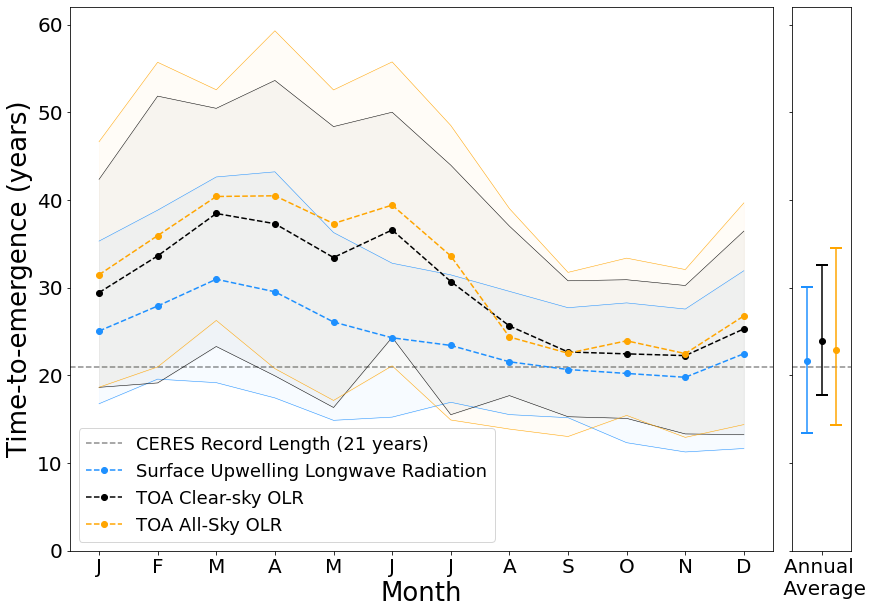

In [49]:
colors = ['dodgerblue','black','orange']

olr_emergence = emergence_LP_allvars['FLUT']

low_err_olr  = olr_emergence.sel(bound=50,method='nearest') - olr_emergence.sel(bound=2.5,method='nearest')
high_err_olr = olr_emergence.sel(bound=97.5,method='nearest') - olr_emergence.sel(bound=50,method='nearest')

olrc_emergence = emergence_LP_allvars['FLUTC']

low_err_olrc  = olrc_emergence.sel(bound=50,method='nearest') - olrc_emergence.sel(bound=2.5,method='nearest')
high_err_olrc = olrc_emergence.sel(bound=97.5,method='nearest') - olrc_emergence.sel(bound=50,method='nearest')

olrs_emergence = emergence_LP_allvars['FLUS']

low_err_olrs  = olrs_emergence.sel(bound=50,method='nearest') - olrs_emergence.sel(bound=2.5,method='nearest')
high_err_olrs = olrs_emergence.sel(bound=97.5,method='nearest') - olrs_emergence.sel(bound=50,method='nearest')

fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

fill_alpha = 0.03

ax1.errorbar(olrs_emergence.sel(month=slice(1,12)).month,
             olrs_emergence.sel(bound=50,month=slice(1,12)), 
             # yerr=[low_err_olrs.sel(month=slice(1,12)),high_err_olrs.sel(month=slice(1,12))],
             fmt="o",
             label='Surface Upwelling Longwave Radiation',
             dash_capstyle='butt',
             color=colors[0],
             capsize=6,
             capthick=2,
             linestyle='dashed',
             # linewidth=0,
            )

ax1.fill_between(olrs_emergence.sel(month=slice(1,12)).month,
             y1=olrs_emergence.sel(bound=2.5,method='nearest').sel(month=slice(1,12)), 
             y2=olrs_emergence.sel(bound=97.5,method='nearest').sel(month=slice(1,12)), 
             # fmt="o",
             # label='Surface OLR',
             color=colors[0],
             # linestyle='dashed',
             alpha=fill_alpha
            )

ax1.plot(olrs_emergence.sel(month=slice(1,12)).month,
         olrs_emergence.sel(bound=2.5,method='nearest').sel(month=slice(1,12)),
         color=colors[0],
         linewidth=0.5,
        )

ax1.plot(olrs_emergence.sel(month=slice(1,12)).month,
         olrs_emergence.sel(bound=97.5,method='nearest').sel(month=slice(1,12)),
         color=colors[0],
         linewidth=0.5,
        )

ax1.errorbar(olrc_emergence.sel(month=slice(1,12)).month, 
             olrc_emergence.sel(bound=50,month=slice(1,12)), 
             # yerr=[low_err_olrc.sel(month=slice(1,12)),high_err_olrc.sel(month=slice(1,12))],
             fmt="o",
             label='TOA Clear-sky OLR',
             dash_capstyle='butt',
             color=colors[1],
             capsize=6,
             capthick=2,
             linestyle='dashed',
            )

ax1.fill_between(olrc_emergence.sel(month=slice(1,12)).month,
             y1=olrc_emergence.sel(bound=2.5,method='nearest').sel(month=slice(1,12)), 
             y2=olrc_emergence.sel(bound=97.5,method='nearest').sel(month=slice(1,12)), 
             # fmt="o",
             # label='Surface OLR',
             color=colors[1],
             # linestyle='dashed',
             alpha=fill_alpha
            )

ax1.plot(olrc_emergence.sel(month=slice(1,12)).month,
         olrc_emergence.sel(bound=2.5,method='nearest').sel(month=slice(1,12)),
         color=colors[1],
         linewidth=0.5,
        )

ax1.plot(olrc_emergence.sel(month=slice(1,12)).month,
         olrc_emergence.sel(bound=97.5,method='nearest').sel(month=slice(1,12)),
         color=colors[1],
         linewidth=0.5,
        )

ax1.errorbar(olr_emergence.sel(month=slice(1,12)).month, 
             olr_emergence.sel(bound=50,month=slice(1,12)), 
             # yerr=[low_err_olr.sel(month=slice(1,12)),high_err_olr.sel(month=slice(1,12))],
             fmt="o",
             label='TOA All-Sky OLR',
             dash_capstyle='butt',
             color=colors[2],
             capsize=6,
             capthick=2,
             linestyle='dashed',
            )

ax1.fill_between(olr_emergence.sel(month=slice(1,12)).month,
             y1=olr_emergence.sel(bound=2.5,method='nearest').sel(month=slice(1,12)), 
             y2=olr_emergence.sel(bound=97.5,method='nearest').sel(month=slice(1,12)), 
             # fmt="o",
             # label='Surface OLR',
             color=colors[2],
             # linestyle='dashed',
             alpha=fill_alpha,
            )

ax1.plot(olr_emergence.sel(month=slice(1,12)).month,
         olr_emergence.sel(bound=2.5,method='nearest').sel(month=slice(1,12)),
         color=colors[2],
         linewidth=0.5,
        )

ax1.plot(olr_emergence.sel(month=slice(1,12)).month,
         olr_emergence.sel(bound=97.5,method='nearest').sel(month=slice(1,12)),
         color=colors[2],
         linewidth=0.5,
        )

### Annual values
ax2.errorbar(0.75, 
             olrs_emergence.sel(bound=50,month=13), 
             yerr=[[low_err_olrs.sel(month=13)],[high_err_olrs.sel(month=13)]], # needs to have shape (2,1)
             fmt="o",
             dash_capstyle='butt',
             color=colors[0],
             capsize=6,
             capthick=2,
            )

ax2.errorbar(1, 
             olrc_emergence.sel(bound=50,month=13), 
             yerr=[[low_err_olrc.sel(month=13)],[high_err_olrc.sel(month=13)]], # needs to have shape (2,1)
             fmt="o",
             dash_capstyle='butt',
             color=colors[1],
             capsize=6,
             capthick=2,
            )

ax2.errorbar(1.25, 
             olr_emergence.sel(bound=50,month=13), 
             yerr=[[low_err_olr.sel(month=13)],[high_err_olr.sel(month=13)]], # needs to have shape (2,1)
             fmt="o",
             dash_capstyle='butt',
             color=colors[2],
             capsize=6,
             capthick=2,
            )

ax1.set_ylim(0,62)
ax1.set_xlim(0.5,12.5)
ax1.set_ylabel('Time-to-emergence (years)',fontsize=26)
ax1.set_xlabel('Month',fontsize=26)

ax1.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
# exp_det_ax.yticks(fontsize=15)

ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)',zorder=0)

ax1.legend(fontsize=18)

ax2.set_xlim(0.5,1.5)
ax2.set_ylim(0,62)

ax2.set_xticks([1])
ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelsize=20)
ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9,zorder=0)

# ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# ax1.set_title('95% confidence intervals on OLR emergence',fontsize=28)


\textbf{Monthly and annual time-to-emergence of longwave radiation variables for members of the CESM1 Large Ensemble.} Purple lines show surface OLR emergence. Black lines show top-of-atmosphere clear-sky OLR emergence. Yellow lines show top-of-atmosphere OLR emergence. Shaded regions and error bars span a $95\%$ confidence interval on estimated time-to-emergence. The dashed grey line indicates the current length of the CERES observational record.

In [50]:
to_png(file=fig,filename='fig_emergence_bylayer_corrected',dpi=300,ext='pdf',bbox_inches='tight')

Combining forced trends (Figure \ref{fig:OLR_bylayer}) and variability (Figure \ref{fig:variability_bylayer}), we present the time-to-emergence of OLR, clear-sky OLR, and surface OLR from the CESM1-LE (Figure \ref{fig:TTE_bylayer}). 

In the Arctic winter, the damping of variability exceeds the damping of forced trends and emergence is accelerated by the atmosphere and clouds. 

For the rest of the year, the atmosphere and clouds delay OLR emergence relative to surface OLR. 

In the annual mean these seasonal influences effectively cancel each other out and clouds merely add uncertainty to OLR emergence.

In [97]:
olr_emergence.sel(month=2)

<xarray.DataArray 'FLUT' (bound: 3)>
array([20.99706667, 35.95055833, 55.86825833])
Coordinates:
  * bound    (bound) float64 2.5 50.0 97.5
    month    int64 2

### Heatmap of OLR and TS

In [60]:
def count_emerged(data,durations):
    
    # empty array for storage
    emerged_count = np.nan * np.ones(durations.shape)

    for i,_dur in enumerate(durations): # iterate over durations

        number_emerged = (data <= _dur).astype('int').sum() # check if emergence has occured

        emerged_count[i] = number_emerged # save data
        
    # return in an xarray format so we can map it across dimensions
    return xr.DataArray(emerged_count,
                        dims=['duration',],
                        coords=dict(duration=durations)
                       )

In [61]:
durations = np.arange(2,81)
number_emerged = {}

for _var in emerge_vars:
    number_emerged[_var] = emergence_LP_allvar[_var].groupby('month').map(count_emerged,durations=durations)


In [62]:
from functions import tick_function1

Text(41.644999999999996, 0.5, 'Likelihood of Climate Signal Emergence (%)')

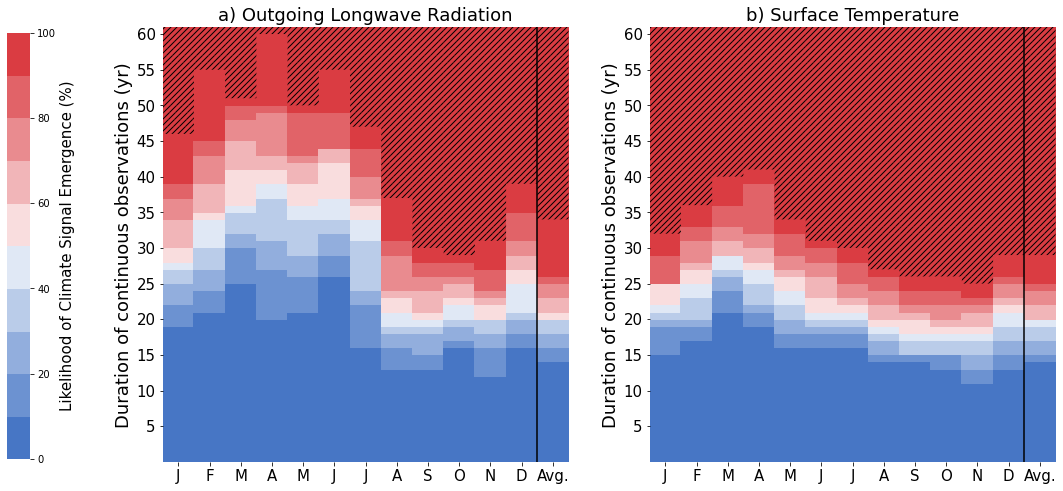

In [63]:
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Avg.']
cmap = sns.diverging_palette(h_neg=254,h_pos=11,s=74,l=50,sep=10,n=10,center='light',as_cmap=False) # 'rocket_r'

detect_fig,detect_axs = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
cbar_axh2 = detect_fig.add_axes([-0.01, 0.13, 0.02, 0.74])

olr_detect_data = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
ts_detect_data = 100*number_emerged['TS'].transpose('duration','month') / 40

im1 = sns.heatmap(olr_detect_data,ax=detect_axs[0],xticklabels=month_labels,cbar=True,cmap=cmap,vmin=0,vmax=100,
                  cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im2 = sns.heatmap(ts_detect_data,ax=detect_axs[1],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

# need to flip because of some weird seaborn convention??
detect_axs[0].invert_yaxis()
detect_axs[1].invert_yaxis()

zm = olr_detect_data.where(olr_detect_data>95)
x = np.arange(0,olr_detect_data.shape[1]+1)       
y = np.arange(0,olr_detect_data.shape[0]+1)
detect_axs[0].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = ts_detect_data.where(ts_detect_data>95)
x = np.arange(0,ts_detect_data.shape[1]+1)       
y = np.arange(0,ts_detect_data.shape[0]+1)
detect_axs[1].pcolor(x, y, zm, hatch='////', alpha=0.)

detect_axs[0].set_yticks(np.arange(5,61,5))
detect_axs[0].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[0].set_ylim(0,61)
detect_axs[0].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[0].set_title('a) Outgoing Longwave Radiation',fontsize=18)
detect_axs[0].vlines(12,0,61,color='black')
detect_axs[0].tick_params(axis='both',labelsize=15)

detect_axs[1].set_yticks(np.arange(5,61,5))
detect_axs[1].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[1].set_ylim(0,61)
detect_axs[1].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[1].set_title('b) Surface Temperature',fontsize=18)
detect_axs[1].vlines(12,0,61,color='black')
detect_axs[1].tick_params(axis='both',labelsize=15)

cbar_axh2.set_ylabel('Likelihood of Climate Signal Emergence (%)',fontsize=15)

# props = dict(facecolor='white', alpha=1)

# detect_axs[0].text(0.5,57.5,'a',fontsize=20,bbox=props)
# detect_axs[1].text(0.5,57.5,'b',fontsize=20,bbox=props)

Text(44.525, 0.5, 'Likelihood of Climate Signal Emergence (%)')

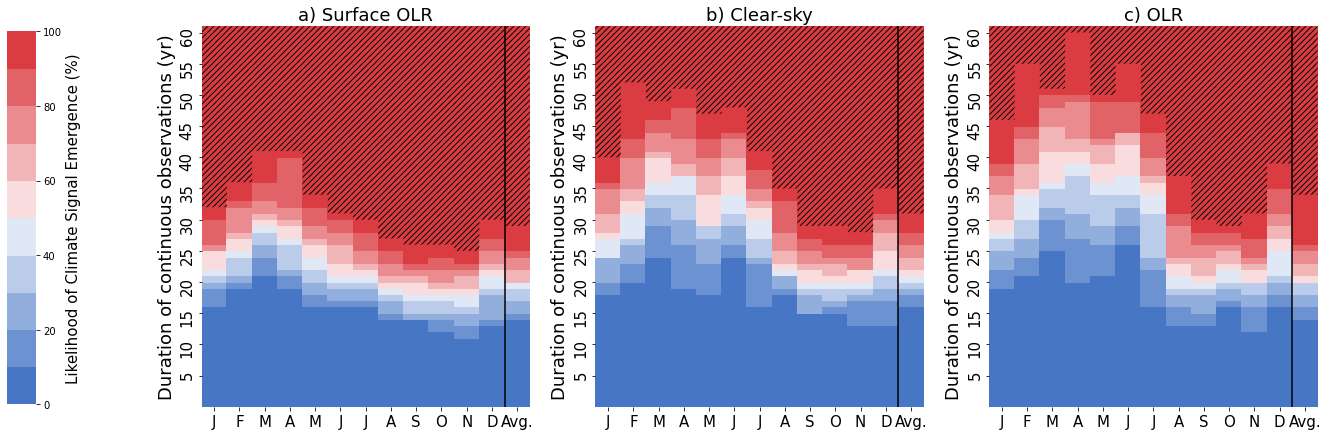

In [64]:
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Avg.']
cmap = sns.diverging_palette(h_neg=254,h_pos=11,s=74,l=50,sep=10,n=10,center='light',as_cmap=False) # 'rocket_r'

detect_fig,detect_axs = plt.subplots(nrows=1,ncols=3,figsize=(20,7))
cbar_axh2 = detect_fig.add_axes([-0.01, 0.13, 0.02, 0.74])

# olr_detect_data = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
# ts_detect_data = 100*number_emerged['TS'].transpose('duration','month') / 40

olr_detect_data  = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
olrc_detect_data = 100*number_emerged['FLUTC'].transpose('duration','month') / 40 # normalize to a percent value
olrs_detect_data = 100*number_emerged['FLUS'].transpose('duration','month') / 40 # normalize to a percent value

im1 = sns.heatmap(olrs_detect_data,ax=detect_axs[0],xticklabels=month_labels,cbar=True,cmap=cmap,vmin=0,vmax=100,
                  cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im2 = sns.heatmap(olrc_detect_data,ax=detect_axs[1],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

im3 = sns.heatmap(olr_detect_data,ax=detect_axs[2],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

# need to flip because of some weird seaborn convention??
detect_axs[0].invert_yaxis()
detect_axs[1].invert_yaxis()
detect_axs[2].invert_yaxis()

zm = olrs_detect_data.where(olrs_detect_data>95)
x = np.arange(0,olrs_detect_data.shape[1]+1)       
y = np.arange(0,olrs_detect_data.shape[0]+1)
detect_axs[0].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olrc_detect_data.where(olrc_detect_data>95)
x = np.arange(0,olrc_detect_data.shape[1]+1)       
y = np.arange(0,olrc_detect_data.shape[0]+1)
detect_axs[1].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olr_detect_data.where(olr_detect_data>95)
x = np.arange(0,olr_detect_data.shape[1]+1)       
y = np.arange(0,olr_detect_data.shape[0]+1)
detect_axs[2].pcolor(x, y, zm, hatch='////', alpha=0.)

detect_axs[0].set_yticks(np.arange(5,61,5))
detect_axs[0].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[0].set_ylim(0,61)
detect_axs[0].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[0].set_title('a) Surface OLR',fontsize=18)
detect_axs[0].vlines(12,0,61,color='black')
detect_axs[0].tick_params(axis='both',labelsize=15)

detect_axs[1].set_yticks(np.arange(5,61,5))
detect_axs[1].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[1].set_ylim(0,61)
detect_axs[1].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[1].set_title('b) Clear-sky',fontsize=18)
detect_axs[1].vlines(12,0,61,color='black')
detect_axs[1].tick_params(axis='both',labelsize=15)

detect_axs[2].set_yticks(np.arange(5,61,5))
detect_axs[2].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[2].set_ylim(0,61)
detect_axs[2].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[2].set_title('c) OLR',fontsize=18)
detect_axs[2].vlines(12,0,61,color='black')
detect_axs[2].tick_params(axis='both',labelsize=15)

cbar_axh2.set_ylabel('Likelihood of Climate Signal Emergence (%)',fontsize=15)

# props = dict(facecolor='white', alpha=1)

# detect_axs[0].text(0.5,57.5,'a',fontsize=20,bbox=props)
# detect_axs[1].text(0.5,57.5,'b',fontsize=20,bbox=props)

Text(151.085, 0.5, 'Likelihood of Climate Signal Emergence (%)')

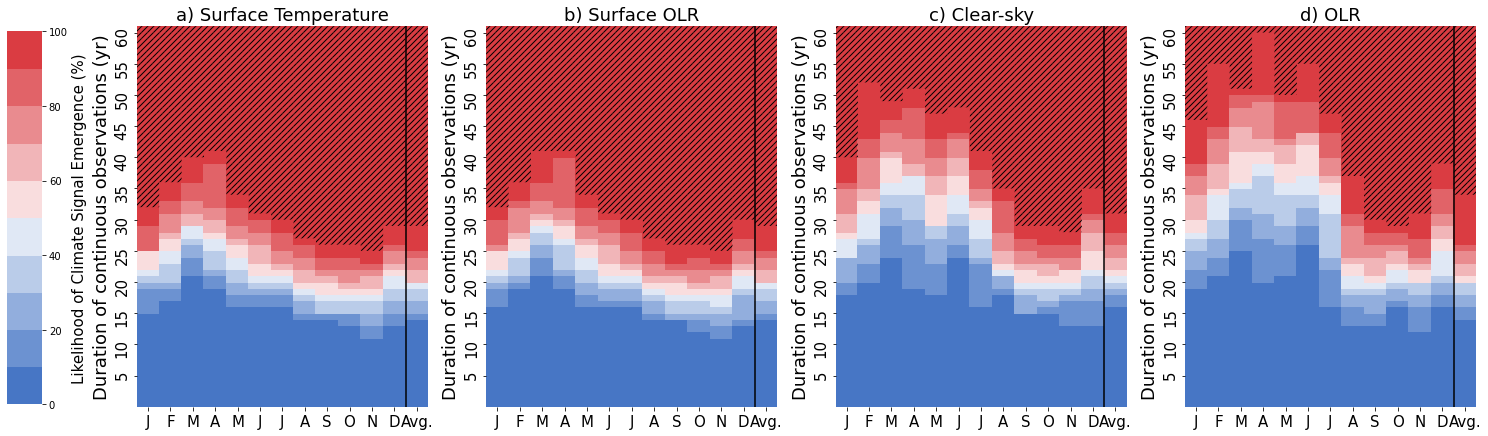

In [65]:
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Avg.']
cmap = sns.diverging_palette(h_neg=254,h_pos=11,s=74,l=50,sep=10,n=10,center='light',as_cmap=False) # 'rocket_r'

detect_fig,detect_axs = plt.subplots(nrows=1,ncols=4,figsize=(24,7))
cbar_axh2 = detect_fig.add_axes([0.05, 0.13, 0.02, 0.74])

# olr_detect_data = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
# ts_detect_data = 100*number_emerged['TS'].transpose('duration','month') / 40

ts_detect_data   = 100*number_emerged['TS'].transpose('duration','month') / 40 # normalize to a percent value
olr_detect_data  = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
olrc_detect_data = 100*number_emerged['FLUTC'].transpose('duration','month') / 40 # normalize to a percent value
olrs_detect_data = 100*number_emerged['FLUS'].transpose('duration','month') / 40 # normalize to a percent value

im0 = sns.heatmap(ts_detect_data,ax=detect_axs[0],xticklabels=month_labels,cbar=True,cmap=cmap,vmin=0,vmax=100,
                  cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im1 = sns.heatmap(olrs_detect_data,ax=detect_axs[1],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100,)
                  # cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im2 = sns.heatmap(olrc_detect_data,ax=detect_axs[2],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

im3 = sns.heatmap(olr_detect_data,ax=detect_axs[3],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

# need to flip because of some weird seaborn convention??
detect_axs[0].invert_yaxis()
detect_axs[1].invert_yaxis()
detect_axs[2].invert_yaxis()
detect_axs[3].invert_yaxis()

zm = ts_detect_data.where(ts_detect_data>95)
x = np.arange(0,ts_detect_data.shape[1]+1)       
y = np.arange(0,ts_detect_data.shape[0]+1)
detect_axs[0].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olrs_detect_data.where(olrs_detect_data>95)
x = np.arange(0,olrs_detect_data.shape[1]+1)       
y = np.arange(0,olrs_detect_data.shape[0]+1)
detect_axs[1].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olrc_detect_data.where(olrc_detect_data>95)
x = np.arange(0,olrc_detect_data.shape[1]+1)       
y = np.arange(0,olrc_detect_data.shape[0]+1)
detect_axs[2].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olr_detect_data.where(olr_detect_data>95)
x = np.arange(0,olr_detect_data.shape[1]+1)       
y = np.arange(0,olr_detect_data.shape[0]+1)
detect_axs[3].pcolor(x, y, zm, hatch='////', alpha=0.)

detect_axs[0].set_yticks(np.arange(5,61,5))
detect_axs[0].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[0].set_ylim(0,61)
detect_axs[0].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[0].set_title('a) Surface Temperature',fontsize=18)
detect_axs[0].vlines(12,0,61,color='black')
detect_axs[0].tick_params(axis='both',labelsize=15)

detect_axs[1].set_yticks(np.arange(5,61,5))
detect_axs[1].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[1].set_ylim(0,61)
detect_axs[1].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[1].set_title('b) Surface OLR',fontsize=18)
detect_axs[1].vlines(12,0,61,color='black')
detect_axs[1].tick_params(axis='both',labelsize=15)

detect_axs[2].set_yticks(np.arange(5,61,5))
detect_axs[2].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[2].set_ylim(0,61)
detect_axs[2].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[2].set_title('c) Clear-sky',fontsize=18)
detect_axs[2].vlines(12,0,61,color='black')
detect_axs[2].tick_params(axis='both',labelsize=15)

detect_axs[3].set_yticks(np.arange(5,61,5))
detect_axs[3].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[3].set_ylim(0,61)
detect_axs[3].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[3].set_title('d) OLR',fontsize=18)
detect_axs[3].vlines(12,0,61,color='black')
detect_axs[3].tick_params(axis='both',labelsize=15)

cbar_axh2.set_ylabel('Likelihood of Climate Signal Emergence (%)',fontsize=15)

# props = dict(facecolor='white', alpha=1)

# detect_axs[0].text(0.5,57.5,'a',fontsize=20,bbox=props)
# detect_axs[1].text(0.5,57.5,'b',fontsize=20,bbox=props)

Text(0.5, 59.640000000000015, 'Likelihood of Climate Signal Emergence (%)')

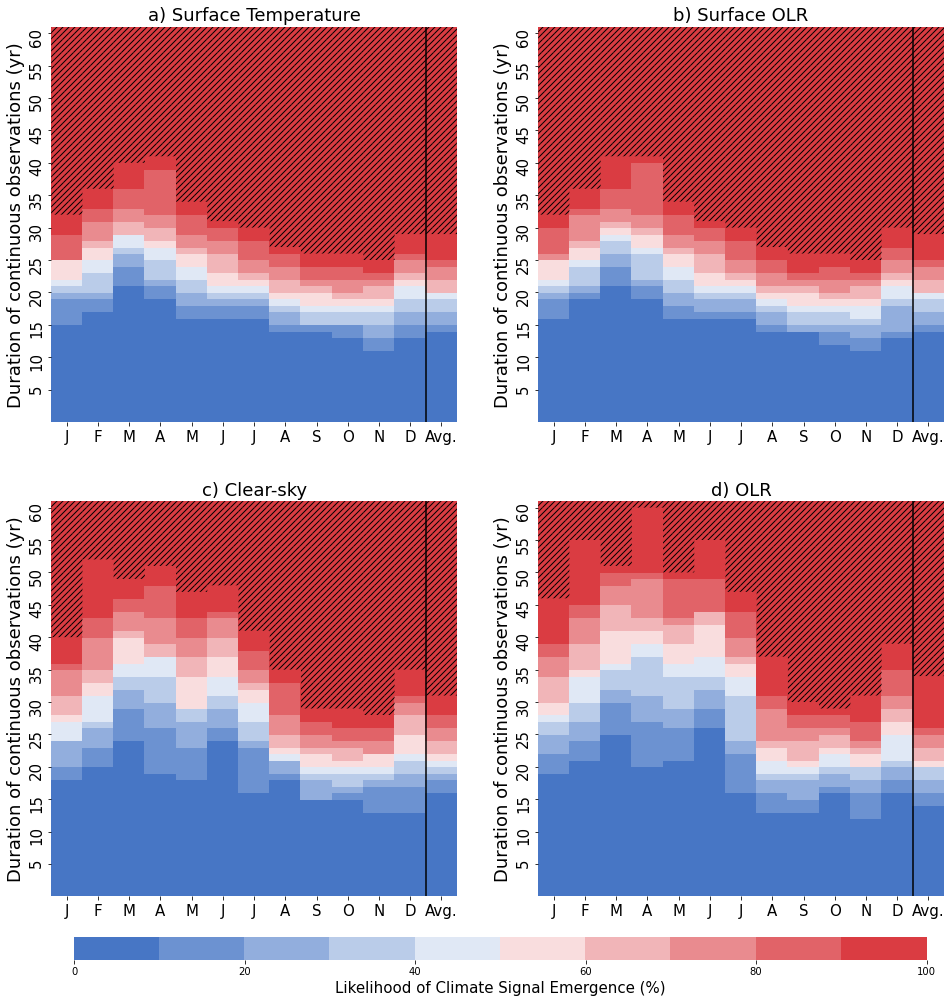

In [66]:
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Avg.']
cmap = sns.diverging_palette(h_neg=254,h_pos=11,s=74,l=50,sep=10,n=10,center='light',as_cmap=False) # 'rocket_r'

detect_fig,detect_axs = plt.subplots(nrows=2,ncols=2,figsize=(16,16))
detect_axs = detect_axs.flat

# cbar_axh2 = detect_fig.add_axes([0.05, 0.13, 0.02, 0.74])
cbar_axh2 = detect_fig.add_axes([0.145, 0.07, 0.74, 0.02])

ts_detect_data   = 100*number_emerged['TS'].transpose('duration','month') / 40 # normalize to a percent value
olr_detect_data  = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
olrc_detect_data = 100*number_emerged['FLUTC'].transpose('duration','month') / 40 # normalize to a percent value
olrs_detect_data = 100*number_emerged['FLUS'].transpose('duration','month') / 40 # normalize to a percent value

im0 = sns.heatmap(ts_detect_data,ax=detect_axs[0],xticklabels=month_labels,cbar=True,cmap=cmap,vmin=0,vmax=100,
                  cbar_ax=cbar_axh2,cbar_kws={'orientation':'horizontal','label':'Likelihood of Climate Signal Detection (%)'})#,'fontsize':15})

im1 = sns.heatmap(olrs_detect_data,ax=detect_axs[1],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100,)
                  # cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im2 = sns.heatmap(olrc_detect_data,ax=detect_axs[2],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

im3 = sns.heatmap(olr_detect_data,ax=detect_axs[3],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

# need to flip because of some weird seaborn convention??
detect_axs[0].invert_yaxis()
detect_axs[1].invert_yaxis()
detect_axs[2].invert_yaxis()
detect_axs[3].invert_yaxis()

zm = ts_detect_data.where(ts_detect_data>95)
x = np.arange(0,ts_detect_data.shape[1]+1)       
y = np.arange(0,ts_detect_data.shape[0]+1)
detect_axs[0].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olrs_detect_data.where(olrs_detect_data>95)
x = np.arange(0,olrs_detect_data.shape[1]+1)       
y = np.arange(0,olrs_detect_data.shape[0]+1)
detect_axs[1].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olrc_detect_data.where(olrc_detect_data>95)
x = np.arange(0,olrc_detect_data.shape[1]+1)       
y = np.arange(0,olrc_detect_data.shape[0]+1)
detect_axs[2].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olr_detect_data.where(olr_detect_data>95)
x = np.arange(0,olr_detect_data.shape[1]+1)       
y = np.arange(0,olr_detect_data.shape[0]+1)
detect_axs[3].pcolor(x, y, zm, hatch='////', alpha=0.)

detect_axs[0].set_yticks(np.arange(5,61,5))
detect_axs[0].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[0].set_ylim(0,61)
detect_axs[0].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[0].set_title('a) Surface Temperature',fontsize=18)
detect_axs[0].vlines(12,0,61,color='black')
detect_axs[0].tick_params(axis='both',labelsize=15)

detect_axs[1].set_yticks(np.arange(5,61,5))
detect_axs[1].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[1].set_ylim(0,61)
detect_axs[1].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[1].set_title('b) Surface OLR',fontsize=18)
detect_axs[1].vlines(12,0,61,color='black')
detect_axs[1].tick_params(axis='both',labelsize=15)

detect_axs[2].set_yticks(np.arange(5,61,5))
detect_axs[2].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[2].set_ylim(0,61)
detect_axs[2].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[2].set_title('c) Clear-sky',fontsize=18)
detect_axs[2].vlines(12,0,61,color='black')
detect_axs[2].tick_params(axis='both',labelsize=15)

detect_axs[3].set_yticks(np.arange(5,61,5))
detect_axs[3].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[3].set_ylim(0,61)
detect_axs[3].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[3].set_title('d) OLR',fontsize=18)
detect_axs[3].vlines(12,0,61,color='black')
detect_axs[3].tick_params(axis='both',labelsize=15)

cbar_axh2.set_xlabel('Likelihood of Climate Signal Emergence (%)',fontsize=15)#,orientation='horizontal')

# props = dict(facecolor='white', alpha=1)

# detect_axs[0].text(0.5,57.5,'a',fontsize=20,bbox=props)
# detect_axs[1].text(0.5,57.5,'b',fontsize=20,bbox=props)

In [337]:
# to_png(file=detect_fig,filename='fig_alllayers_monthlyemergence',dpi=300,ext='pdf',bbox_inches='tight')

Text(41.644999999999996, 0.5, 'Likelihood of Climate Signal Emergence (%)')

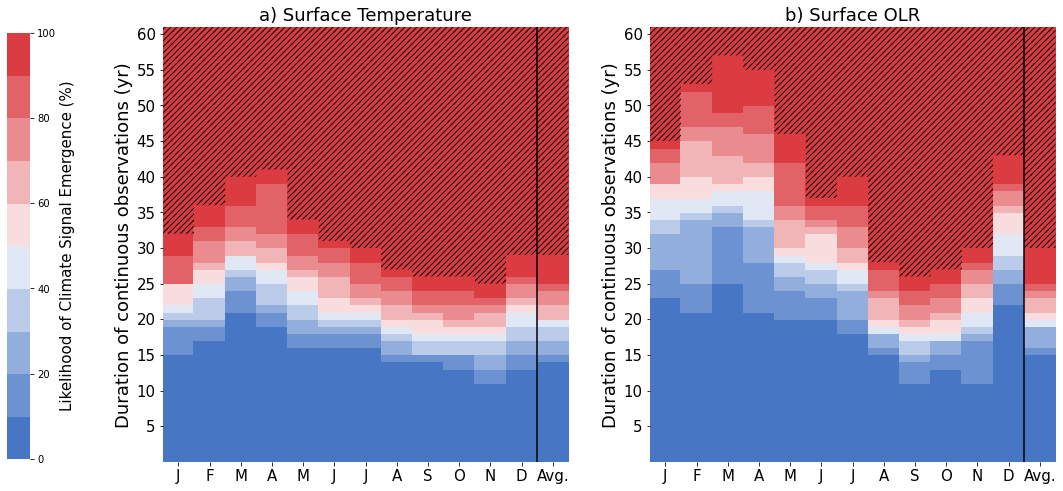

In [51]:
month_labels = ['J','F','M','A','M','J','J','A','S','O','N','D','Avg.']
cmap = sns.diverging_palette(h_neg=254,h_pos=11,s=74,l=50,sep=10,n=10,center='light',as_cmap=False) # 'rocket_r'

detect_fig,detect_axs = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
cbar_axh2 = detect_fig.add_axes([-0.01, 0.13, 0.02, 0.74])

# olr_detect_data = 100*number_emerged['FLUT'].transpose('duration','month') / 40 # normalize to a percent value
# ts_detect_data = 100*number_emerged['TS'].transpose('duration','month') / 40

ts_detect_data  = 100*number_emerged['TS'].transpose('duration','month') / 40 # normalize to a percent value
olr_detect_data = 100*number_emerged['FLUS'].transpose('duration','month') / 40 # normalize to a percent value

im1 = sns.heatmap(ts_detect_data,ax=detect_axs[0],xticklabels=month_labels,cbar=True,cmap=cmap,vmin=0,vmax=100,
                  cbar_ax=cbar_axh2,cbar_kws={'orientation':'vertical','label':'Likelihood of Climate Signal Detection (%)'})

im2 = sns.heatmap(olr_detect_data,ax=detect_axs[1],xticklabels=month_labels,cbar=False,cmap=cmap,vmin=0,vmax=100)

# need to flip because of some weird seaborn convention??
detect_axs[0].invert_yaxis()
detect_axs[1].invert_yaxis()

zm = ts_detect_data.where(ts_detect_data>95)
x = np.arange(0,ts_detect_data.shape[1]+1)       
y = np.arange(0,ts_detect_data.shape[0]+1)
detect_axs[0].pcolor(x, y, zm, hatch='////', alpha=0.)

zm = olr_detect_data.where(olr_detect_data>95)
x = np.arange(0,olr_detect_data.shape[1]+1)       
y = np.arange(0,olr_detect_data.shape[0]+1)
detect_axs[1].pcolor(x, y, zm, hatch='////', alpha=0.)

detect_axs[0].set_yticks(np.arange(5,61,5))
detect_axs[0].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[0].set_ylim(0,61)
detect_axs[0].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[0].set_title('a) Surface Temperature',fontsize=18)
detect_axs[0].vlines(12,0,61,color='black')
detect_axs[0].tick_params(axis='both',labelsize=15)

detect_axs[1].set_yticks(np.arange(5,61,5))
detect_axs[1].set_yticklabels(tick_function1(np.arange(5,61,5)))
detect_axs[1].set_ylim(0,61)
detect_axs[1].set_ylabel('Duration of continuous observations (yr)',fontsize=18)
detect_axs[1].set_title('b) Surface OLR',fontsize=18)
detect_axs[1].vlines(12,0,61,color='black')
detect_axs[1].tick_params(axis='both',labelsize=15)

cbar_axh2.set_ylabel('Likelihood of Climate Signal Emergence (%)',fontsize=15)

# props = dict(facecolor='white', alpha=1)

# detect_axs[0].text(0.5,57.5,'a',fontsize=20,bbox=props)
# detect_axs[1].text(0.5,57.5,'b',fontsize=20,bbox=props)

The .pdf save gets layers wrong (likely doesn't play well with sns.heatmap?). So I also save as a .png

In [52]:
# to_png(file=detect_fig,filename='fig_OLRvTS_emergence',dpi=300,ext='pdf',bbox_inches='tight')

In [53]:
# to_png(file=detect_fig,filename='fig_OLRvTS_emergence',dpi=300,ext='png',bbox_inches='tight')

Differences between OLR and TS.

In [54]:
emergence_LP_allvars['FLUT'].sel(bound='50') - emergence_LP_allvars['TS'].sel(bound='50')

<xarray.DataArray (month: 13)>
array([ 6.60986667,  8.83524167,  9.63031667, 11.13704167, 11.21280833,
       15.06508333, 10.28314167,  2.491325  ,  1.73959167,  3.5093    ,
        2.63604167,  4.43850833,  1.33680833])
Coordinates:
    bound    float64 50.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13

## Old

### Layer-by-layer mean emergence comparison

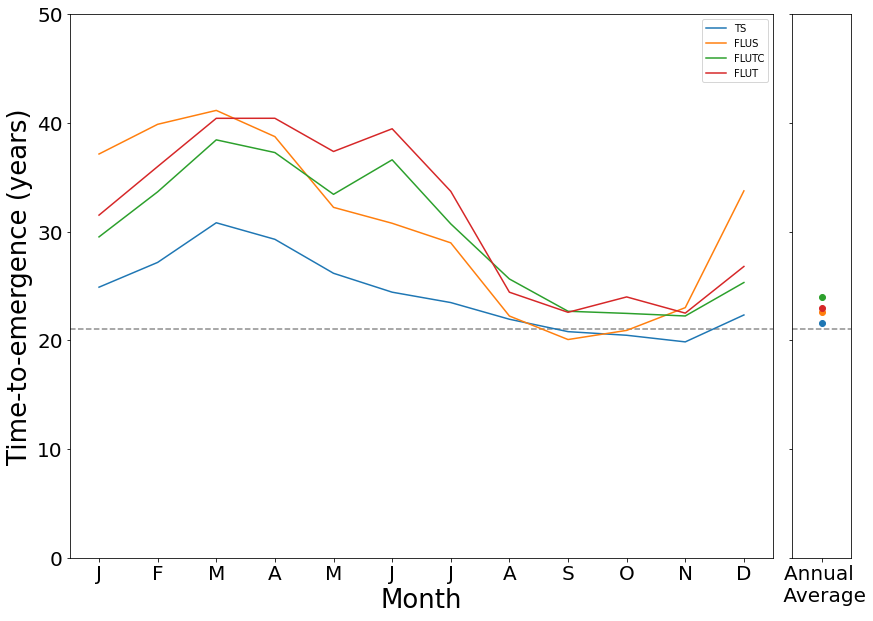

In [34]:
layer_vars = ['TS','FLUS','FLUTC','FLUT']

# olr_emergence_test = emergence_LP_allvars['FLUT']

# low_err  = olr_emergence_test.sel(bound=50,method='nearest') - olr_emergence_test.sel(bound=2.5,method='nearest')
# high_err = olr_emergence_test.sel(bound=97.5,method='nearest') - olr_emergence_test.sel(bound=50,method='nearest')

fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0]) # months
ax2 = plt.subplot(gs[1]) # annual

for _var in layer_vars:
    ax1.plot(emergence_LP_allvars[_var].sel(month=slice(1,12)).month,
             emergence_LP_allvars[_var].sel(bound=50,month=slice(1,12)),
             label=_var,
            )
             
    ax2.scatter(1,
             emergence_LP_allvars[_var].sel(bound=50,month=13),
            )

ax1.legend()

ax1.set_ylim(0,50) # 67
ax1.set_xlim(0.5,12.5)
ax1.set_ylabel('Time-to-emergence (years)',fontsize=26)
ax1.set_xlabel('Month',fontsize=26)

ax1.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
# exp_det_ax.yticks(fontsize=15)

ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)')

ax2.set_xlim(0.5,1.5)
ax2.set_ylim(0,50)

ax2.set_xticks([1])
ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelsize=20)
ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9)

# ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# ax1.set_title('95% confidence intervals on OLR emergence',fontsize=28)


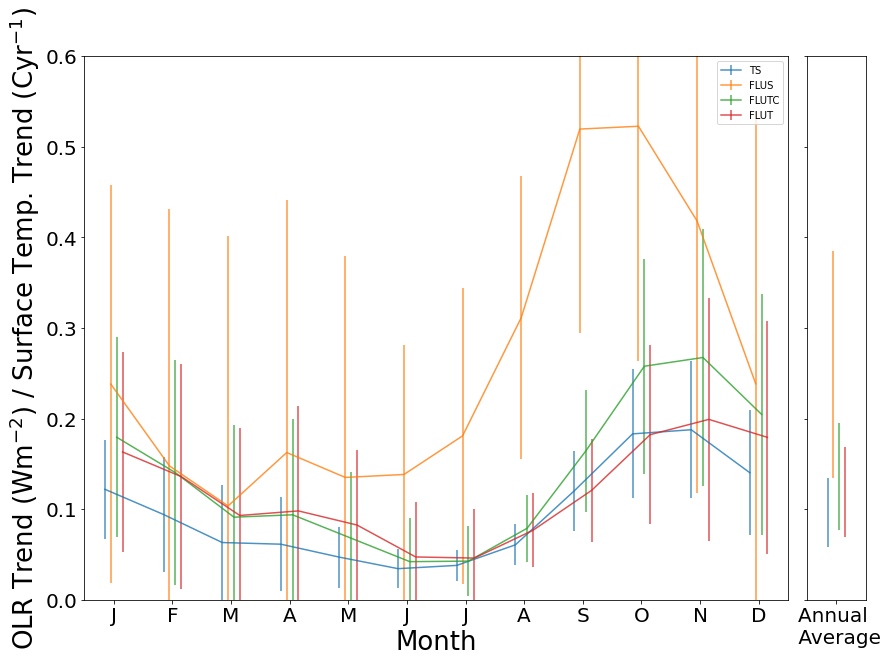

In [35]:
layer_vars = ['TS','FLUS','FLUTC','FLUT']

# olr_emergence_test = emergence_LP_allvars['FLUT']

# low_err  = olr_emergence_test.sel(bound=50,method='nearest') - olr_emergence_test.sel(bound=2.5,method='nearest')
# high_err = olr_emergence_test.sel(bound=97.5,method='nearest') - olr_emergence_test.sel(bound=50,method='nearest')

meanslopes_21years = slopes_all_ds.sel(duration=21).mean(dim='ens')
stdslopes_21years  = slopes_all_ds.sel(duration=21).std(dim='ens')

fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0]) # months
ax2 = plt.subplot(gs[1]) # annual

for i,_var in enumerate(layer_vars):
    
    _offset = -0.15 + i*0.1
    
    ax1.errorbar(meanslopes_21years[_var].sel(month=slice(1,12)).month+_offset,
                 meanslopes_21years[_var].sel(month=slice(1,12)),
                 yerr=stdslopes_21years[_var].sel(month=slice(1,12)),
                 alpha=0.8,
                 label=_var,
                )
             
    ax2.errorbar(1+_offset,
                 meanslopes_21years[_var].sel(month=13),
                 yerr=stdslopes_21years[_var].sel(month=13),
                 alpha=0.8,
                )
    
#     ax1.plot(meanslopes_21years[_var].sel(month=slice(1,12)).month,
#              meanslopes_21years[_var].sel(month=slice(1,12)),
#              label=_var,
#             )
             
#     ax2.scatter(1,
#              meanslopes_21years[_var].sel(month=13),
#             )

ax1.legend()

ax1.set_xlim(0.5,12.5)
ax1.set_ylim(0,0.6) # 67
ax1.set_ylabel('OLR Trend (Wm$^{-2}$) / Surface Temp. Trend (Cyr$^{-1}$)',fontsize=26)
ax1.set_xlabel('Month',fontsize=26)

ax1.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
# exp_det_ax.yticks(fontsize=15)

# ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)')

ax2.set_xlim(0.5,1.5)
ax2.set_ylim(0,0.6)

ax2.set_xticks([1])
ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelsize=20)
# ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9)

# ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# ax1.set_title('95% confidence intervals on OLR emergence',fontsize=28)


Text(0, 0.5, 'SNR')

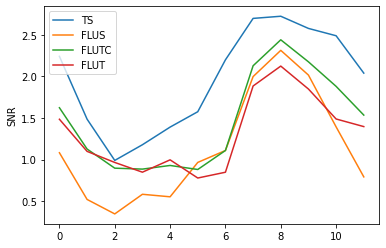

In [36]:

for _var in layer_vars:
    plt.plot(meanslopes_21years[_var].sel(month=slice(1,12)) / stdslopes_21years[_var].sel(month=slice(1,12)),label=_var)
    
plt.legend()

plt.ylabel('SNR')

Look at the variability sky-rocket when going from TS to FLUS. But it happens over all months, not just the spring. So the atmosphere is still important.